<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw1/Homework1_MADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1

In [1]:
!nvidia-smi

Sun Nov  7 12:14:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 100 (delta 32), reused 54 (delta 14), pack-reused 0
Receiving objects: 100% (100/100), 26.18 MiB | 25.05 MiB/s, done.
Resolving deltas: 100% (32/32), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./dul_202

In [3]:
from dul_2021.utils.hw1_utils import *

In [4]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [8., 6.]

# MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


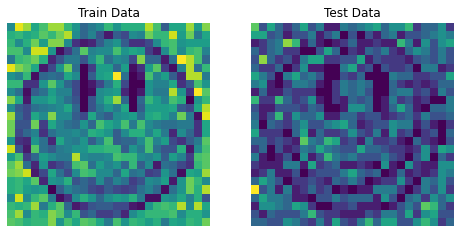

Dataset 2


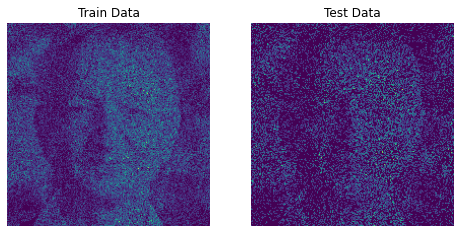

In [ ]:
visualize_q1a_data(dset_type=1)
visualize_q1a_data(dset_type=2)
# you can access data with get_data_q1_a(dset_type=1)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm

In [34]:
def one_hot(x, n):  
    if not isinstance(x, torch.Tensor):
        x = torch.Tensor(x).long()
    return F.one_hot(x, n)

def eval(model, dataloader, device, d):
    num_test = len(dataloader.dataset) 
    tmp_loss = 0.0
    for x in iter(dataloader):
        with torch.no_grad():
            x = x.long().to(device)
            x_one_hot = one_hot(x, d).float().to(device)
            x_pred = model(x_one_hot)
            
            loss = F.cross_entropy(x_pred.reshape(-1, d), x.reshape(-1))         
            tmp_loss += loss.item() * x.shape[0]
    return tmp_loss / num_test

def train(model, train_data, test_data, d, lr=1e-3, bs=100, epochs=20, device='cuda'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_dl = DataLoader(
        train_data, 
        batch_size=bs, 
        shuffle=True
    )

    test_dl = DataLoader(
        test_data, 
        batch_size=bs, 
        shuffle=False
    )

    train_losses, test_losses = [], []
    for epoch in tqdm(range(epochs)):
        if epoch == 0:
            test_losses.append(eval(model, test_dl, device, d))            
        
        model.train()
        for x in iter(train_dl):
            x = x.long().to(device)
            x_one_hot = one_hot(x, d).float().to(device)
            optimizer.zero_grad()
            x_pred = model(x_one_hot)
            
            loss = F.cross_entropy(x_pred.reshape(-1, d), x.reshape(-1))
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
        
        model.eval()
        test_losses.append(eval(model, test_dl, device, d=d))

    return train_losses, test_losses


In [7]:
class MaskedLinear(nn.Linear):    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        mask = torch.Tensor(mask.T)
        self.mask.copy_(mask)
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


class MADE(nn.Module):
    def __init__(self, nin, d, hidden_size):
        super().__init__()
        self.m = {}
        # some init
        self.nin = nin
        self.hidden_size = hidden_size
        self.L = len(self.hidden_size)
        self.d = d
        self.test_input = None

        self.make_masks()

        layers = []
        masked_lin = MaskedLinear(in_features=nin * self.d, out_features=self.hidden_size[0])
        masked_lin.set_mask(self.masks[0])
        layers.extend([masked_lin, nn.ReLU()])
        
        for i in range(self.L-1):
            masked_lin = MaskedLinear(in_features=self.hidden_size[i], out_features=self.hidden_size[i+1])
            masked_lin.set_mask(self.masks[i+1])
            layers.extend([masked_lin, nn.ReLU()])

        masked_lin = MaskedLinear(in_features=self.hidden_size[self.L-1], out_features=self.nin * self.d)
        masked_lin.set_mask(self.masks[self.L])
        layers.extend([masked_lin])

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        inp = x.reshape(x.shape[0], -1)
        inp = self.network(inp)
        inp = inp.reshape(-1, self.nin, self.d)
        return inp

    def make_masks(self):
        # L = num of hidden layers
        # nin = input dim
        # d = number of values per dim
                
        self.m[-1] = np.arange(self.nin) # or some other ordering
        for l in range(self.L):
            self.m[l] = np.random.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_size[l])
        
        self.masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(self.L)]
        self.masks.append(self.m[self.L-1][:,None] < self.m[-1][None,:])
        self.masks[0] = np.repeat(self.masks[0], self.d, axis=0)
        self.masks[-1] = np.repeat(self.masks[-1], self.d, axis=1)
        
    def distribution(self):
        if self.test_input is None:
            self.test_input_idxs = torch.cartesian_prod(torch.arange(self.d), torch.arange(self.d)).to('cuda')
            self.test_input = one_hot(self.test_input_idxs, n=self.d).float()
        with torch.no_grad():
            output = self.forward(self.test_input)
            output = F.softmax(output, dim=2).detach()
            probs = torch.empty((self.d, self.d))
            for k, (i, j) in enumerate(self.test_input_idxs):
                probs[i, j] = (output[k, 0, i] * output[k, 1, j]).cpu()
        return probs.numpy()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q1_a(train_data, test_data, d, dset_id):
        """
        train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
        test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
        d: The number of possible discrete values for each random variable x1 and x2
        dset_id: An identifying number of which dataset is given (1 or 2). Most likely
        used to set different hyperparameters for different datasets

        Returns
        - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
        - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
        - a numpy array of size (d, d) of probabilities (the learned joint distribution)
        """
        if dset_id == 1:
                hidden_size = [256, 512, 256]
                nin = 2
        if dset_id == 2:
                hidden_size = [512, 1024, 512]
                nin = 2
        model = MADE(nin=nin, d=d, hidden_size=hidden_size)
        train_losses, test_losses = train(model, train_data, test_data, d=d)
        distr = model.distribution()
        
        return train_losses, test_losses, distr


### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Final Test Loss: 3.1834


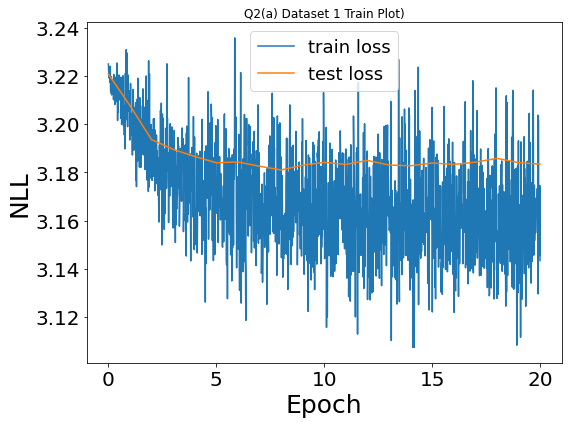

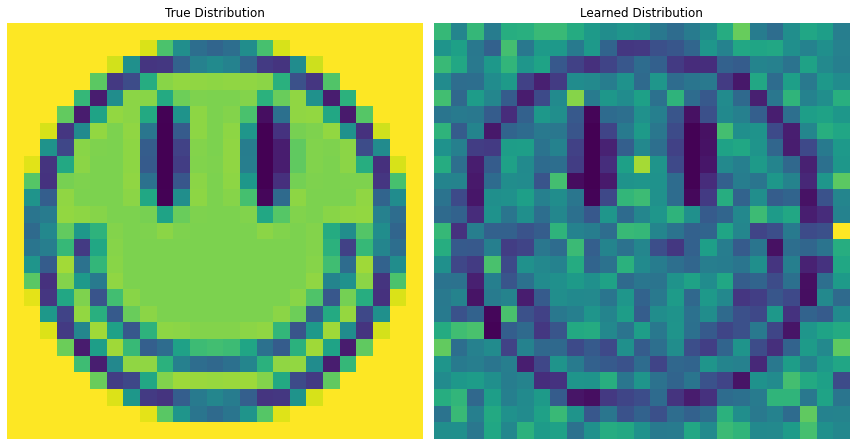

In [ ]:
q1_save_results(1, 'a', q1_a)

100%|██████████| 20/20 [01:04<00:00,  3.22s/it]


Final Test Loss: 5.3375


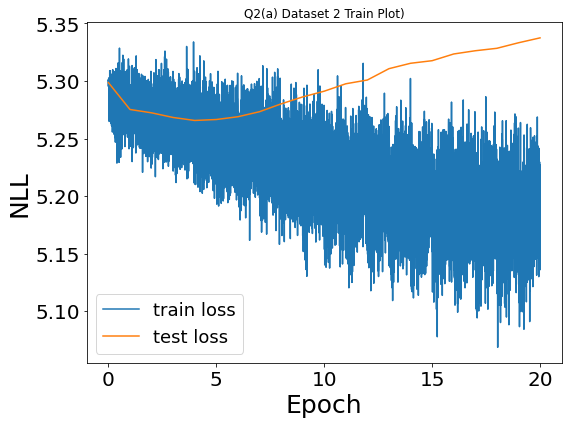

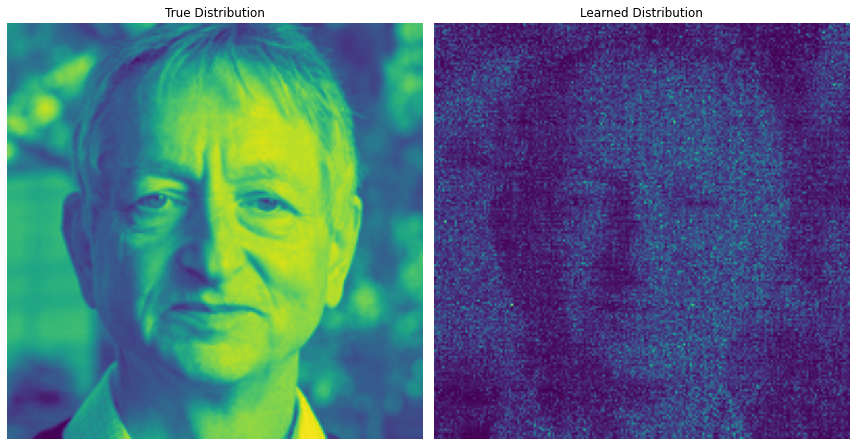

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

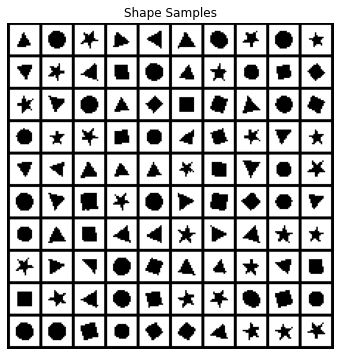

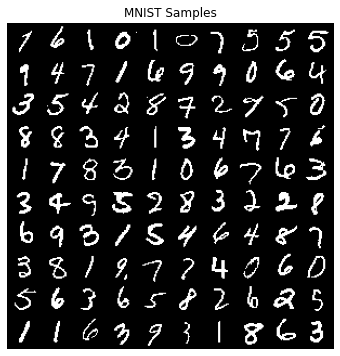

In [ ]:
visualize_q1b_data(1)
visualize_q1b_data(2)
# you can access data with get_data_q1_b(dset_type=1)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

In [66]:
class MADE_B(nn.Module):
    def __init__(self, nin, h, w, hidden_size):
        super().__init__()
        self.m = {}
        # some init
        self.nin = nin
        self.hidden_size = hidden_size
        self.L = len(self.hidden_size)
        self.h = h
        self.w = w
        self.test_input = None

        self.make_masks()

        layers = []
        masked_lin = MaskedLinear(in_features=nin * self.h * self.w, out_features=self.hidden_size[0])
        masked_lin.set_mask(self.masks[0])
        layers.extend([masked_lin, nn.ReLU()])
        
        for i in range(self.L-1):
            masked_lin = MaskedLinear(in_features=self.hidden_size[i], out_features=self.hidden_size[i+1])
            masked_lin.set_mask(self.masks[i+1])
            layers.extend([masked_lin, nn.ReLU()])

        masked_lin = MaskedLinear(in_features=self.hidden_size[self.L-1], out_features=self.nin * self.h * self.w)
        masked_lin.set_mask(self.masks[self.L])
        layers.extend([masked_lin])

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        inp = x.reshape(x.shape[0], -1)
        inp = self.network(inp)
        inp = inp.reshape(-1, self.h * self.w, self.nin)
        return inp

    def make_masks(self):
        # L = num of hidden layers
        # nin = input dim
        # d = number of values per dim
                
        self.m[-1] = np.arange(self.nin) # or some other ordering
        for l in range(self.L):
            self.m[l] = np.random.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_size[l])
        
        self.masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(self.L)]
        self.masks.append(self.m[self.L-1][:,None] < self.m[-1][None,:])
        self.masks[0] = np.repeat(self.masks[0], self.h * self.w, axis=0)
        self.masks[-1] = np.repeat(self.masks[-1], self.h * self.w, axis=1)
        
    def samples(self, n=100):
        output = torch.randint(low=0, high=2, size=(n, self.h, self.w, 1)).to('cuda')
        samples = output.view(n, self.h * self.w)

        with torch.no_grad():
            for i in range(self.h * self.w):
                test_input = one_hot(output, n=2).float()
                output_new = self.forward(test_input)[:, i, :]
                output_new = torch.distributions.categorical.Categorical(logits=output_new).sample()
                
                samples[:, i] = output_new
                output = samples.view(n, self.h, self.w, 1)

        return samples.reshape(n, self.h, self.w, 1).cpu().numpy()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [82]:
def q1_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    if dset_id == 1:
          hidden_size = [128, 256, 128]
          nin = 2
          epochs = 50
          bs = 30
          lr = 1e-2
    if dset_id == 2:
          hidden_size = [512, 1024, 512]
          nin = 2
          epochs = 80
          bs = 120
          lr = 1e-3
    h,w = image_shape
    model = MADE_B(nin=nin, h=h, w=w, hidden_size=hidden_size)
    train_losses, test_losses = train(model, train_data, test_data, d=2, epochs=epochs, bs=bs, lr=lr)
    samples = model.samples()
    
    return train_losses, test_losses, samples



### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


Final Test Loss: 0.0981


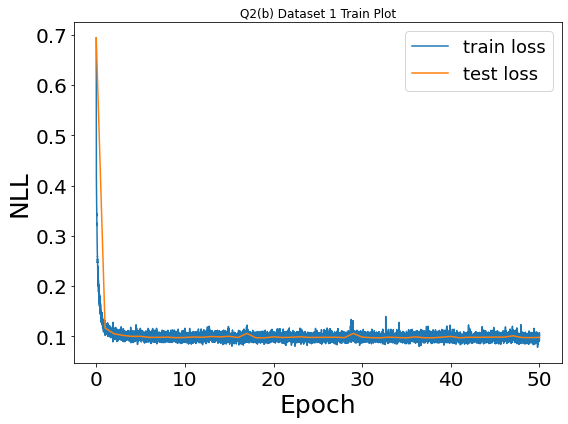

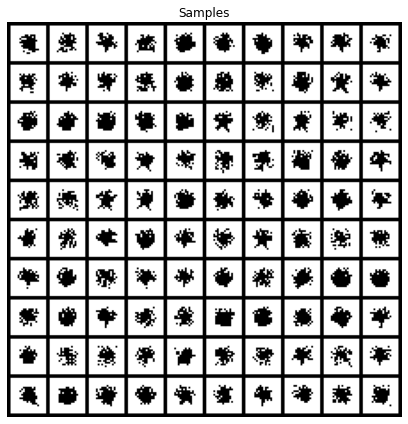

In [75]:
q1_save_results(1, 'b', q1_b)

100%|██████████| 80/80 [07:47<00:00,  5.84s/it]


Final Test Loss: 0.2437


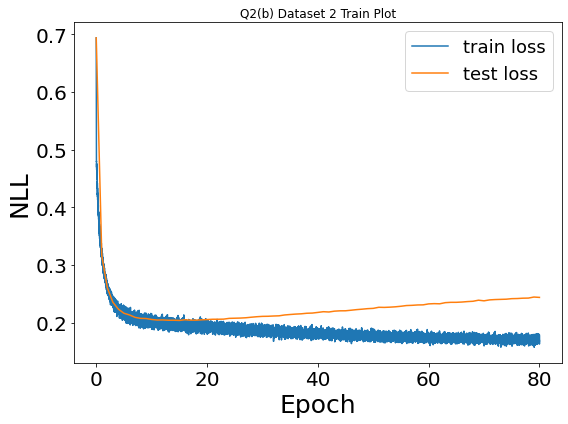

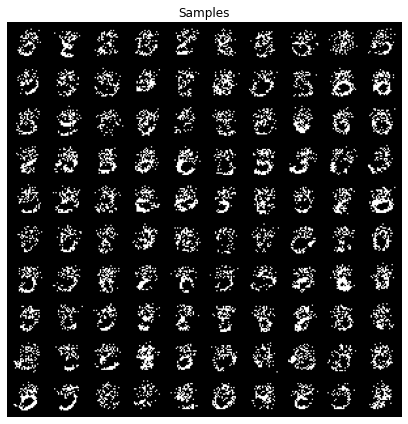

In [83]:
q1_save_results(2, 'b', q1_b)